## Imports

In [1]:
import sys
sys.path.append('/vinbrain/huyta/domainadaptation/ssda/')

In [2]:
from ssda.learner import Learner, auxs
from ssda.model import AdaptationModel
from ssda.dataset import AdaptationDataset

## Configs

In [3]:
n_aux_classes = 5
auxs = auxs
aux_labels = [90, 45, 0, -45, -90]
img_size = 256

## Create Model

In [4]:
import torch
from torch import nn
sys.path.append('/vinbrain/huyta/')
from COVID_wave_4.utils.layers import PooledSelfAttention2d, AdaptiveConcatPool
from COVID_wave_4.utils.fastai_utils import create_effnet

# modified version
class SAPoolClassifier(nn.Sequential):
    def __init__(self, in_c, out_c):
        super(SAPoolClassifier, self).__init__()
        self.SA = PooledSelfAttention2d(in_c)
        self.pool = AdaptiveConcatPool()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(in_c*2), nn.Dropout(0.25), nn.Linear(in_c*2, 512), nn.ReLU(),
            nn.BatchNorm1d(512), nn.Dropout(0.5), nn.Linear(512, out_c)
        )

In [5]:
model = nn.Sequential(create_effnet(False, 'tf_efficientnet_b5_ns'), SAPoolClassifier(2048, 5))
states  = torch.load('/vinbrain/huyta/COVID_wave_4/train_notebooks/models/train_all_512_no_fastai.pth')
model.load_state_dict(states, strict=False)

<All keys matched successfully>

In [6]:
backbone = nn.Sequential(model[0], model[1].SA, model[1].pool, nn.Flatten())
classifier = model[1].fc

In [7]:
adapt_model = AdaptationModel(backbone=backbone, classifier=classifier, n_aux_classes=n_aux_classes)

In [8]:
adapt_model = nn.DataParallel(adapt_model, device_ids=[0, 1])
adapt_model.cuda();

## Dataset

In [9]:
import pandas as pd

data_path = '/u01/data/COVID_Data_Relabel/data/'
label_cols_list = ['Covid', 'Airspace_Opacity', 'Consolidation', 'Atelectasis', 'Lung_Lesion']

source_df_train = pd.read_csv('/vinbrain/huyta/COVID_wave_4/csv/train_clean.csv')
source_df_valid = pd.read_csv('/vinbrain/huyta/COVID_wave_4/csv/valid_clean.csv')

source_df_train['Images'] = data_path + source_df_train['Images']
source_df_valid['Images'] = data_path + source_df_valid['Images']

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


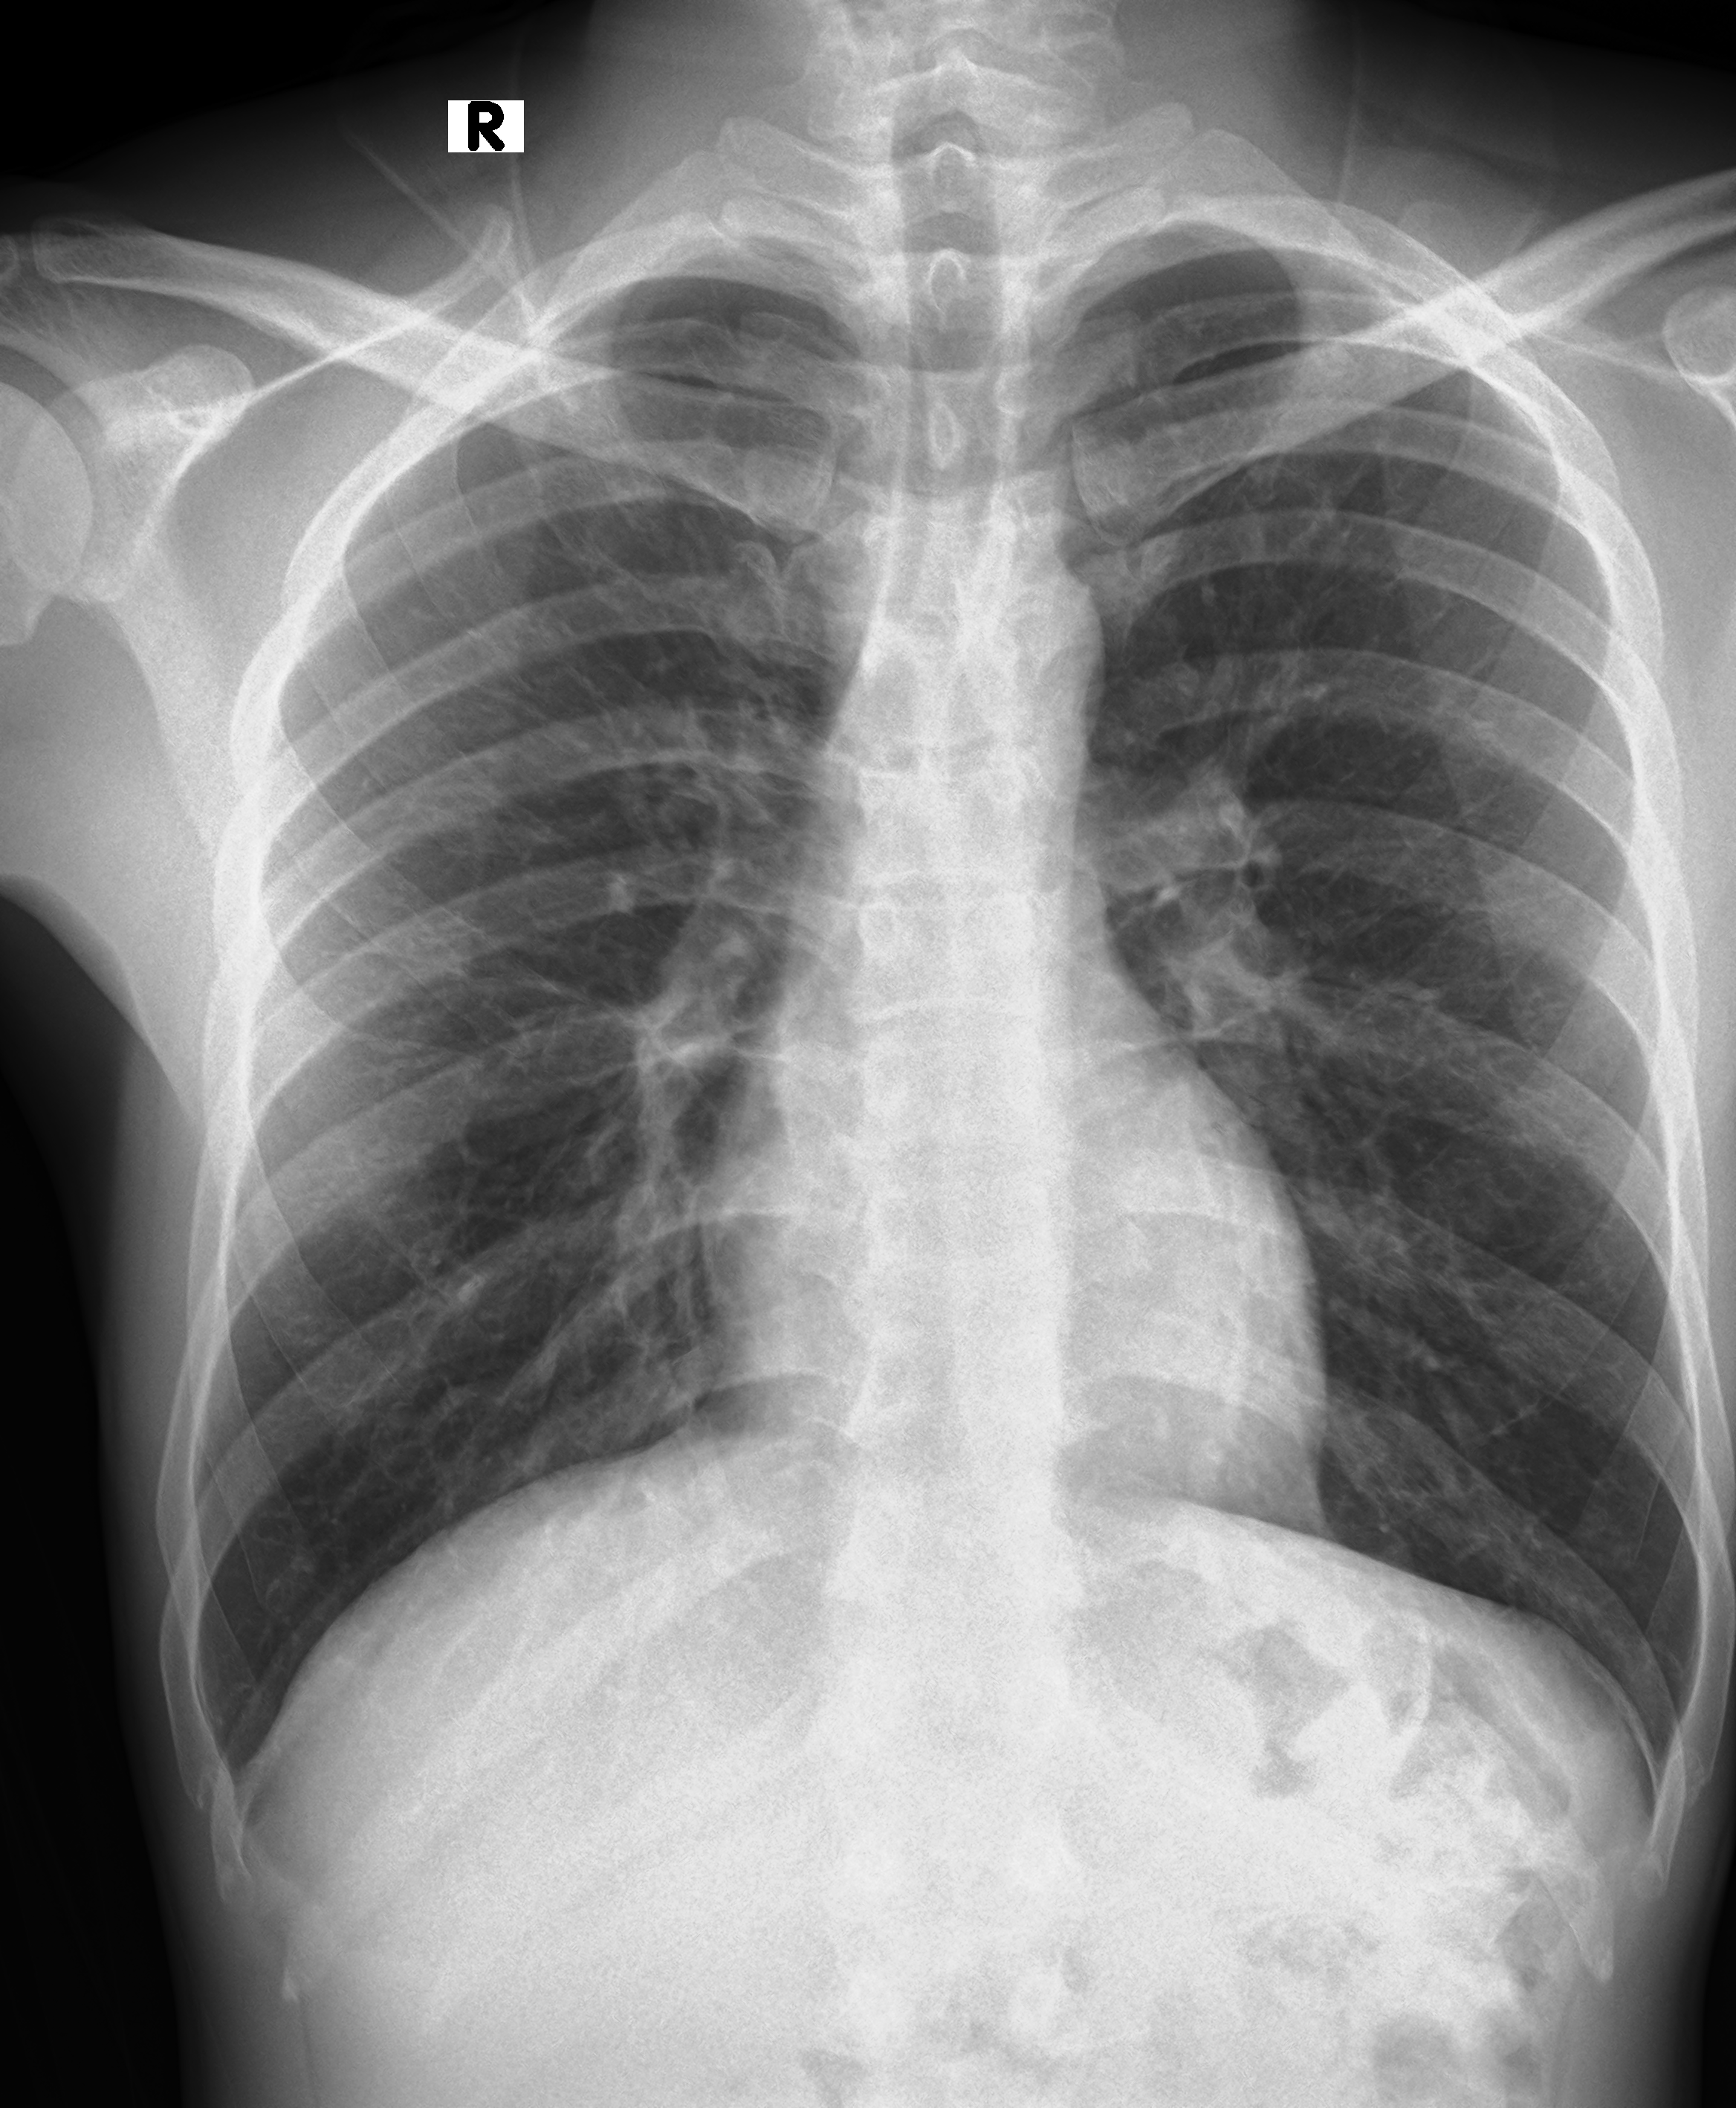

In [10]:
from pathlib import Path
from PIL import Image

target_imgs = Path('/vinbrain/huyta/COVID_wave_4/data/bacgiang/all_imgs/').rglob('*.png')
target_imgs = [str(c) for c in target_imgs if 'ipynb' not in str(c)][1:]
target_df = pd.DataFrame({'Images': target_imgs})
Image.open(target_df.at[0, 'Images'])

In [11]:
from torchvision.transforms import *

train_augs = Compose([
    ToPILImage(),
    RandomResizedCrop(img_size, (0.8, 1.25)),
    RandomApply([ColorJitter(brightness=(0.2), contrast=(0.85, 1.0))], p=0.4),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_augs = Compose([
    ToPILImage(),
    Resize(img_size),
    CenterCrop(img_size),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [12]:
train_ds = AdaptationDataset(auxs, source_df_train, target_df, train_augs, label_cols_list)
valid_ds = AdaptationDataset(auxs, source_df_valid, target_df, valid_augs, label_cols_list)

In [13]:
from TedAI.tedai import make_imgs
import numpy as np

  pip install torch-lr-finder -v --global-option="amp"


                                         source:  45                                                    target:  0


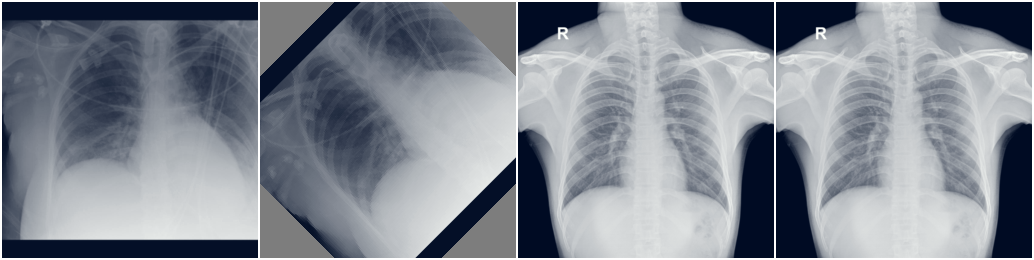

In [14]:
sample_src, sample_tgt = train_ds[np.random.randint(0, len(train_ds))]
x_src, xa_src = sample_src['x'], sample_src['xa']
x_tgt, xa_tgt = sample_tgt['x'], sample_tgt['xa']

a_src, a_tgt = sample_src['a'], sample_tgt['a']

batch = torch.stack([x_src, xa_src, x_tgt, xa_tgt])
print(' '*40, 'source: ', aux_labels[a_src.item()], ' '*50, 'target: ', aux_labels[a_tgt.item()])
make_imgs(batch, 4, plot=False)

                                         source:  45                                                    target:  45


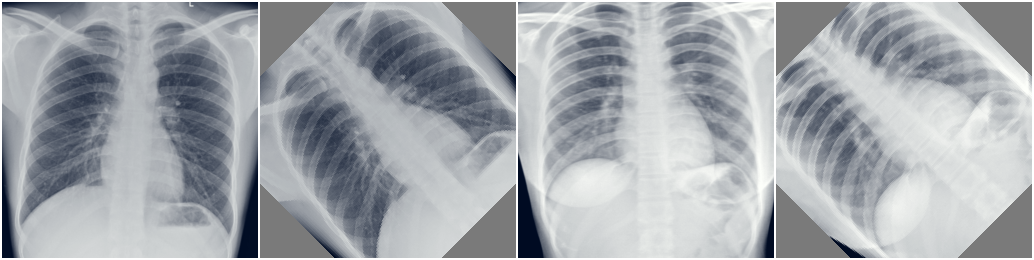

In [15]:
sample_src, sample_tgt = valid_ds[np.random.randint(0, len(valid_ds))]
x_src, xa_src = sample_src['x'], sample_src['xa']
x_tgt, xa_tgt = sample_tgt['x'], sample_tgt['xa']

a_src, a_tgt = sample_src['a'], sample_tgt['a']

batch = torch.stack([x_src, xa_src, x_tgt, xa_tgt])
print(' '*40, 'source: ', aux_labels[a_src.item()], ' '*50, 'target: ', aux_labels[a_tgt.item()])
make_imgs(batch, 4, plot=False)

In [16]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=16, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)

dataloaders = [train_dl, valid_dl]

## Train

In [17]:
W = {
    'w_src_aux': 0.5,
    'w_src_kld': 0.5,
    'w_tgt_aux': 0.5,
    'w_tgt_kld': 0.5,
    'w_tgt_ent': 0.1,
}

In [18]:
learn = Learner(model=adapt_model, dataloaders=dataloaders, name='first_run', W=W)

In [19]:
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
n_epochs = 5
optimizer = Adam(adapt_model.parameters(), lr=1e-3)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, total_steps=len(dataloaders[0])*n_epochs)

In [20]:
learn.fit(n_epochs, optimizer, scheduler)

,loss,src_loss,src_class_loss,src_aux_loss,src_kld_loss,tgt_loss,tgt_aux_loss,tgt_kld_loss,tgt_ent_loss,src_class_f1,src_aux_accuracy,tgt_aux_accuracy
0,9.420117739809598,4.2754988188277165,0.46987814815986617,0.17538642953149974,7.435854911804199,5.144618920981884,0.21769491577288136,8.25623220205307,9.076552733778954,0.815385,0.95,0.942


,loss,src_loss,src_class_loss,src_aux_loss,src_kld_loss,tgt_loss,tgt_aux_loss,tgt_kld_loss,tgt_ent_loss,src_class_f1,src_aux_accuracy,tgt_aux_accuracy
1,2.739782022094041,2.2832704775646926,2.216597886021227,0.060024655947927386,0.07332052713900339,0.4565115445293486,0.05507274059345946,0.04813885985640809,4.049057483673096,0.224599,0.99,0.992


,loss,src_loss,src_class_loss,src_aux_loss,src_kld_loss,tgt_loss,tgt_aux_loss,tgt_kld_loss,tgt_ent_loss,src_class_f1,src_aux_accuracy,tgt_aux_accuracy
2,2.775816451118683,2.0053814857391474,1.9139867865877962,0.007630666663317243,0.17515873163938522,0.7704349653795362,0.028989767881284934,0.21113486774265766,6.503726355731487,0.223801,1.0,0.988


,loss,src_loss,src_class_loss,src_aux_loss,src_kld_loss,tgt_loss,tgt_aux_loss,tgt_kld_loss,tgt_ent_loss,src_class_f1,src_aux_accuracy,tgt_aux_accuracy
3,2.771022393233169,1.9524199737748384,1.8476654833316823,0.017402905534254387,0.19210607535205781,0.8186024194583297,0.016892601241124794,0.23861556267365813,6.9084832072258,0.223801,0.996,0.998


,loss,src_loss,src_class_loss,src_aux_loss,src_kld_loss,tgt_loss,tgt_aux_loss,tgt_kld_loss,tgt_ent_loss,src_class_f1,src_aux_accuracy,tgt_aux_accuracy
4,2.7200510341605586,2.0091476522317566,1.9244011878287597,0.012185310508357361,0.1573076182976365,0.7109033819288015,0.015356864274508553,0.2015060381963849,6.02471924200654,0.223801,0.998,0.996
